Импортируем библиотеки:

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import nn
from sklearn.feature_selection import SelectKBest

%matplotlib inline

Загружаем данные из CSV. Данные преобразовываются в CSV с помощью утилиты `make_dataset`, которая собирается вместе с `SoFCheck`'ом

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data

,winner,game_id,board_total,board_left,psq.cost.0,psq.cost.1,psq.cost.2,psq.cost.3,psq.cost.4,psq.cost.5,...,psq.king_end.63,queen_near_to_king,two_bishops,pawn_isolated,pawn_double,pawn_passed,pawn_candidate,pawn_open,pawn_protected,pawn_backward
0,1.0,64808,144,84,256,0,0,-256,256,0,...,-96,-512,0,512,0,0,0,256,256,0
1,0.0,88564,113,79,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.5,73859,141,52,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-256,0
3,0.5,1690,142,60,-256,0,0,0,0,0,...,0,0,0,0,0,-256,0,0,0,0
4,0.0,15591,121,42,0,0,0,0,0,0,...,0,0,0,-512,0,-256,0,256,256,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,0.0,27657,143,112,256,0,0,0,0,0,...,0,0,0,256,0,0,256,0,0,0
2999996,1.0,11347,166,152,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-512,0
2999997,1.0,40768,146,84,-512,0,0,256,0,0,...,0,0,0,0,0,-256,0,-256,0,0
2999998,1.0,40032,118,15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dv = data.values

Делим выборку на обучающую и тестовую. Деление осуществляем по `game_id`, чтобы позиции из одной игры не оказались в разных выборках.

In [5]:
games = np.array([i+1 for i in range(data['game_id'].max())])

games_train, games_test = train_test_split(games, test_size=0.1, shuffle=True)

In [6]:
train_set = set(games_train)
test_set = set(games_test)

is_train = np.vectorize(lambda x: x in train_set)
is_test = np.vectorize(lambda x: x in test_set)

dv_train = dv[is_train(dv[:,1])]
dv_test = dv[is_test(dv[:,1])]

In [7]:
del data
del dv

In [8]:
X = dv_train[:,4:]
y = dv_train[:,0]
w = dv_train[:,3]

X_test = dv_test[:,4:]
y_test = dv_test[:,0]
w_test = dv_test[:,3]

del dv_train
del dv_test

Создаем нашу модель. Здесь используется модель, описанная [на Хабре](https://habr.com/ru/post/305604/), только мы не пишем градиентный спуск руками, а используем силу PyTorch

In [34]:
model = nn.Sequential()
model.add_module('linear', nn.Linear(X.shape[1], 1, bias=False))
model.add_module('sigmoid', nn.Sigmoid())

In [35]:
opt = torch.optim.Adam(model.parameters(), lr=2e-5)

Определяем функцию потерь:

In [36]:
def get_loss(model, X, y, w, C=0.0):
    w = np.exp(-w / 32.)
    y_pred = model(X)[:, 0]
    assert y_pred.dim() == 1
    loss = torch.sum(w * ((y - y_pred) ** 2)) / torch.sum(w)
    loss += C * torch.norm(model.linear.weight, 1)
    return loss

Обучаем, пока не сойдется функция потерь. Для этого может быть полезно запустить ячейку несколько раз. А может быть, ее стоит остановить раньше.

In [39]:
C = 0.003

history = []

for i in range(6000):
    # собираем батч
    indices = np.random.randint(0, X.shape[0], 8000)
    X_batch = torch.tensor(X[indices], dtype=torch.float32)
    y_batch = torch.tensor(y[indices], dtype=torch.float32)
    w_batch = torch.tensor(w[indices], dtype=torch.float32)
    
    # считаем функцию потерь
    loss = get_loss(model, X_batch, y_batch, w_batch, C=C)

    loss.backward()
    
    # надо раскомментить, если хочется менять только короля
    # model.linear.weight.grad[0, 0:6+64] = 0
    # model.linear.weight.grad[0, 6+64:6+384] = 0
    # model.linear.weight.grad[0, 6+448:] = 0
    
    # оптимизируем
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())

    # выводим результаты
    if i % 100 == 0:
        test_loss = get_loss(model,
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.float32),
            torch.tensor(w_test, dtype=torch.float32),
            C=0.0).detach().numpy().sum()
        train_loss = np.mean(history[-40:])
        print(f"step #{i}, train_loss = {train_loss:.4f}, test_loss = {test_loss:.4f}")

step #0, train_loss = 0.0569, test_loss = 0.0558
step #100, train_loss = 0.0560, test_loss = 0.0557
step #200, train_loss = 0.0557, test_loss = 0.0558
step #300, train_loss = 0.0559, test_loss = 0.0557
step #400, train_loss = 0.0559, test_loss = 0.0557
step #500, train_loss = 0.0561, test_loss = 0.0558
step #600, train_loss = 0.0561, test_loss = 0.0557
step #700, train_loss = 0.0560, test_loss = 0.0557
step #800, train_loss = 0.0558, test_loss = 0.0558
step #900, train_loss = 0.0556, test_loss = 0.0557
step #1000, train_loss = 0.0558, test_loss = 0.0557
step #1100, train_loss = 0.0559, test_loss = 0.0558
step #1200, train_loss = 0.0561, test_loss = 0.0557
step #1300, train_loss = 0.0562, test_loss = 0.0558
step #1400, train_loss = 0.0558, test_loss = 0.0557
step #1500, train_loss = 0.0561, test_loss = 0.0557
step #1600, train_loss = 0.0564, test_loss = 0.0557
step #1700, train_loss = 0.0559, test_loss = 0.0558
step #1800, train_loss = 0.0560, test_loss = 0.0558
step #1900, train_loss =

Смотрим на итоговое значение функции потерь на тестовом датасете:

In [40]:
test_loss = get_loss(model,
                     torch.tensor(X_test, dtype=torch.float32),
                     torch.tensor(y_test, dtype=torch.float32),
                     torch.tensor(w_test, dtype=torch.float32)).detach().numpy().sum()
test_loss

0.0557491

Ради интереса посмотрим на вероятности, которые предсказывает модель для каких-то $20$ соседних примеров тестовой выборки:

In [41]:
res = model(torch.tensor(X_test, dtype=torch.float32))[:, 0]

print(res[450:470], y_test[450:470])

tensor([0.7313, 0.4944, 0.5270, 0.4219, 0.6114, 0.5054, 0.9509, 0.2340, 0.0658,
        0.5788, 0.6555, 0.6599, 0.4722, 0.4813, 0.4709, 0.9859, 0.2266, 0.6138,
        0.5086, 0.9240], grad_fn=<SliceBackward>) [0.5 0.5 0.  0.  0.5 0.5 1.  0.  0.  0.5 0.5 0.5 0.  0.  0.5 0.5 0.  0.5
 0.  1. ]


Теперь было бы неплохо преобразовать веса модели в коэффициенты, которые мы будем использовать в шахматной программе. Для этого нормируем таблицы фигура-поле так, чтобы медианное значение занулилось. Затем умножим все веса на одно и то же число так, чтобы стоимость пешки была равна `100` (т. е. одной пешке)

In [42]:
ws = (model.linear.weight[0]).detach().numpy()
for p in [0, 2, 3, 4, 5]:
    left = 6 + 64 * p
    right = 6 + 64 * (p + 1)
    if p == 0:
        # верхний и нижний ряд у пешки не используется, не обращаем на него внимание
        left += 8
        right -= 8
    m = np.median(ws[left:right])
    ws[left:right] -= m
    ws[p] += m

ww = (ws / ws[0] * 100).astype(np.int32)
print(ww)

[ 100    0  371  404  647 1197    0    0    0    0    0    0    0    0
  174  206  204  150  177  158  182  154   96   99   77   57   55   72
   89   74   24   22   -8    1   19    5    7    7  -11   -8  -14  -14
  -19   -1   -9  -13  -13  -18  -22  -27  -15  -18   -6  -18  -15  -12
  -18  -57  -17   -1    3  -20    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    1    0    0    1    0
    0    0    0   -1    0   -3    0    0    0   -1    0   -2    1    0
    0    0    0   -1    0    0    0    0    0    1    0    0    2    0
    0    0    1    7   -5  -10    7   -2   -9   -3    0    6   34   65
 -106   42   24  -52    2  -91   69   35    0   -2    0    0    7    0
   -4    0  -22    0    5   27    8    8   -3  -14    0   12   38   41
   49   47   34    1  -11   -8   46   57   52   62   53   17  -24   -3
   22   22   45   39   32   23  -71  -23  -10   12   29   22    1   -8
  -49   -9   -2   -1   -7    0  -19   -7 -122  -66  -15  -35  -21  -26
   -5 

Эти веса уже можно скопировать, вставить в утилиту `apply_weigths` и использовать в `SoFCheck`'е.

Далее визуализируем полученные веса:

In [18]:
def display_mat(mat):
    plt.matshow(mat)
    for (x, y), value in np.ndenumerate(mat):
        plt.text(y, x, f"{value}", va="center", ha="center")

Стоимости фигур:

In [19]:
ww[:6]

array([ 100,    0,  344,  371,  597, 1087], dtype=int32)

Таблицы фигура-поле для пешки:

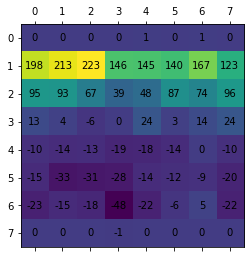

In [20]:
display_mat(ww[6:6+64].reshape(8, 8))

Таблицы фигура-поле для короля в миттельшпиле:

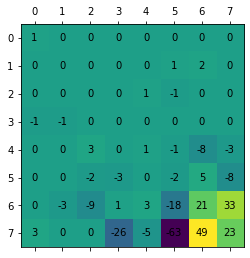

In [21]:
display_mat(ww[6+64:6+128].reshape(8, 8))

Таблицы фигура-поле для коня:

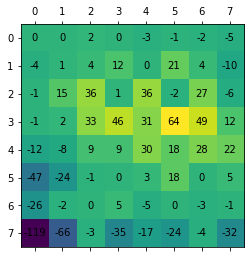

In [22]:
display_mat(ww[6+128:6+192].reshape(8, 8))

Таблицы фигура-поле для слона:

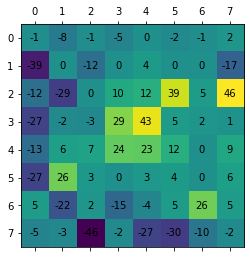

In [23]:
display_mat(ww[6+192:6+256].reshape(8, 8))

Таблицы фигура-поле для ладьи:

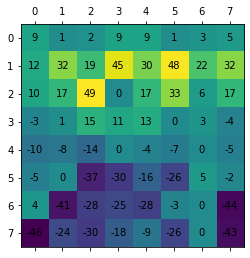

In [24]:
display_mat(ww[6+256:6+320].reshape(8, 8))

Таблицы фигура-поле для ферзя:

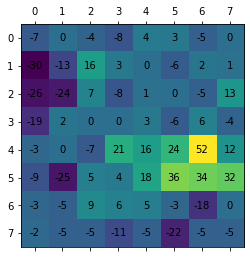

In [25]:
display_mat(ww[6+320:6+384].reshape(8, 8))

Таблицы фигура-поле для короля в эндшпиле:

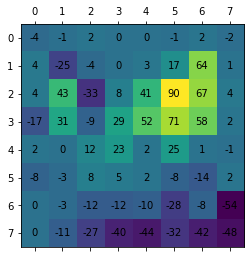

In [26]:
display_mat(ww[6+384:6+448].reshape(8, 8))

Стоимость ферзя, близкого к вражескому королю, и стоимость двух слонов:

In [27]:
ww[454], ww[455]

(58, 30)

Стоимость пешек: изолированная, двойная, проходная:

In [28]:
ww[456], ww[457], ww[458]

(-6, -3, 48)